In [5]:
import pandas as pd
from job_estimation import *
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

In [6]:
# load observed resource usage data
jobres_df = pd.read_csv("job-resource-stats.csv")
jobres_df

,rho,input_size,time,memory
0,prior,1000,12:24:00,4.40
1,prior,5000,51:33:00,7.93
2,prior,10000,01:42:35,11.85
3,prior,20000,05:49:49,26.42
4,prior,50000,NaN,155.90
5,prior,100000,NaN,559.36


In [7]:
# load states from demographic data
demo_df = pd.read_csv("../data/us-dem-counts-jan-2021-with-neighbors.csv", index_col=False)
demo_df.head()

,spatial_id,name.x,NativePercent,BlackNotHispPercent,HispanicPercent,Population,X_GIS,Y_GIS,FID,name.y,...,county,type_of_test,test_processing,lat,long,accuracy,formatted_addr,census_block,census_tract,NumProviders
0,10010201001,"BG0201001, Autauga County, AL",1.1080,13.9889,3.1856,722.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10010201002,"BG0201002, Autauga County, AL",1.1067,13.7549,2.6087,1265.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10010202001,"BG0202001, Autauga County, AL",0.5825,67.8641,3.6893,1030.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10010202002,"BG0202002, Autauga County, AL",0.0830,56.3485,4.4813,1205.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,10010203001,"BG0203001, Autauga County, AL",0.4277,23.0171,3.2659,2572.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [26]:
# count rows by state
state_counts = demo_df.groupby('state').count()['spatial_id']
state_counts = state_counts.reset_index().sort_values(by='spatial_id', ascending=True)
state_counts = state_counts.rename(columns={'spatial_id':'blockgroups'}).reset_index(drop=True)

# interpolate power function for memory usage prediction
popt, _ = fit_and_label(fit_func_power, jobres_df["input_size"], jobres_df["memory"], num_params=3)

# predict memory usage for each state
state_counts['memory'] = fit_func_power(state_counts['blockgroups'], *popt)
state_counts = state_counts.sort_values(by='memory')

state_counts

,state,blockgroups,memory
0,WY,410,3.997261
1,DC,450,4.000623
2,VT,522,4.007367
3,AK,534,4.008576
4,ND,572,4.012567
5,DE,574,4.012784
6,SD,654,4.022001
7,RI,815,4.043736
8,MT,842,4.047792
9,HI,875,4.052908


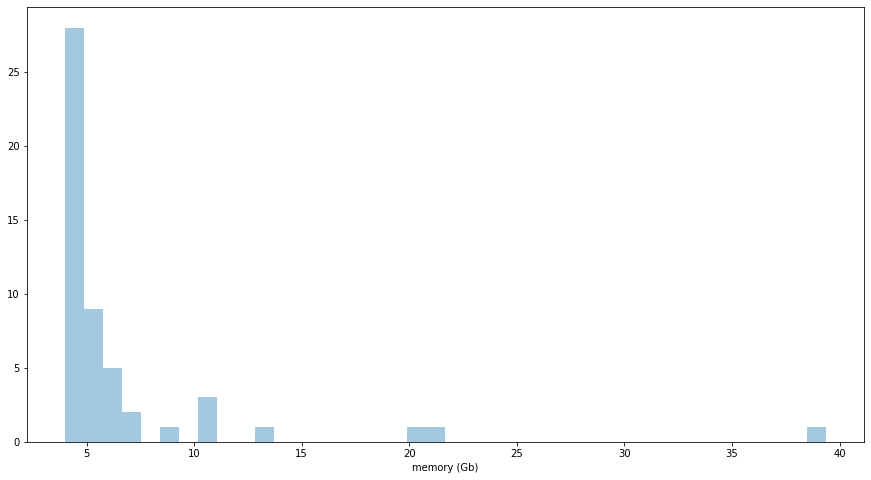

In [10]:
plt.figure(figsize=(15, 8))
sns.distplot(state_counts['memory'], kde=False);
plt.xlabel('memory (Gb)');

In [31]:
def line_text(x, y, text_column, data, title, xlabel, ylabel, kwargs):
    """Line plot with state names on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the line plot
    p1 = sns.lineplot(x, y, data=data, size = 8, legend=False, **kwargs)
    # Add text besides each point
    for i in range(data.shape[0]):
        if i % 2 == 0:
            delta_y = 1.2  
            align = 'right'
        else:
            delta_y = -1.2  
            align = 'left'
        p1.text(data[x][i], data[y][i]+delta_y, 
                 data[text_column][i], horizontalalignment=align, 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

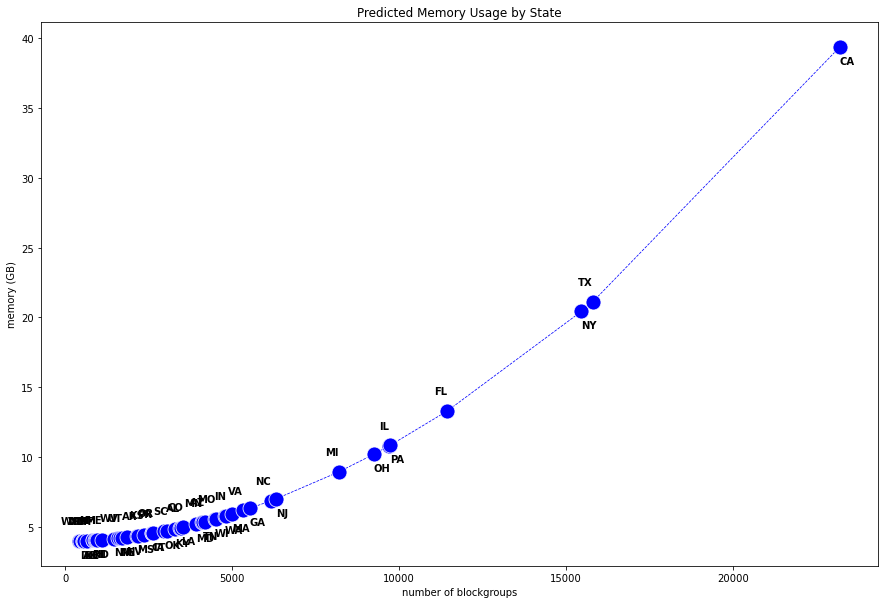

In [32]:
plt.figure(figsize=(15, 10))
kwargs = dict(linestyle='--', color='b', marker ='o', linewidth=1.2, markersize=15)
line_text('blockgroups', 'memory', 'state', state_counts, 
             "Predicted Memory Usage by State", "number of blockgroups", "memory (GB)",
            kwargs);